## import some data (text), clean, and use a keras encoder/decoder LSTM RNN to generate summaries

In [1]:
import numpy as np
import pandas as pd 
import requests, re, spacy
nlp = spacy.load('en')
from bs4 import BeautifulSoup as BS
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### reading in data with Pandas

In [2]:
reviews=pd.read_csv("data/Reviews.csv",nrows=100000)

In [3]:
reviews.drop_duplicates(subset=['Text'],inplace=True)
reviews.dropna(axis=0,inplace=True)

In [4]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


### contraction dictionary

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

### defining text cleaner function

In [6]:
stop = set(stopwords.words('english')) 

def clean_line(text,num):
        '''
        clean_line

        input: line (str) - a line from the script
        return: list of cleaned, lemetized tokens

        This does all the NLP preprocessing:
            * lower text
            * split on special characters, while removing annotations
            * remove stop words
            * perform lemmetization
            *** MIGHT REMOVE IMPORTANT WORDS IDK MAN
        '''
        line = text.lower()
        line = BS(line, "lxml").text
        line = re.sub(r'\([^)]*\)', '', line)
        line = re.sub('"','', line)
        line = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in line.split(" ")])    
        line = re.sub(r"'s\b","",line)
        line = re.sub("[^a-zA-Z]", " ", line) 
        line = re.sub('[m]{2,}', 'mm', line)
        if(num==0):
            tokens = [w for w in line.split() if not w in stop]
        else:
            tokens=line.split()
        long_words=[]
        for i in tokens:
            if len(i)>1:                                                
                long_words.append(i)   
        return (" ".join(long_words)).strip()

### running the above function on the 'Text' column, this takes a while

In [7]:
cleaned_text = []
for t in reviews['Text']:
    cleaned_text.append(clean_line(t,0))

In [8]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [9]:
cleaned_summ = []
for t in reviews['Summary']:
    cleaned_summ.append(clean_line(t,1))

In [10]:
cleaned_summ[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [11]:
df = pd.DataFrame()

In [12]:
df['Text']= cleaned_text

In [13]:
df['Summary']= cleaned_summ

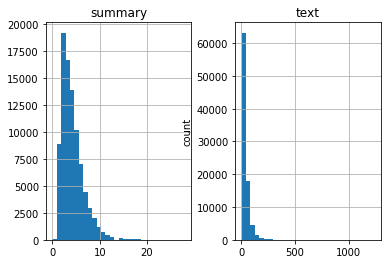

In [23]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# plotting distribution of word/text lengths
for i in df['Text']:
      text_word_count.append(len(i.split()))

for i in df['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('count')
plt.show()

In [24]:
df.Text = df.Text.apply(str)
df.Summary = df.Summary.apply(str)

In [25]:
df.to_csv('training2.csv',index=False)


In [26]:
from data.processor import DataProcessor
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN
from keras.optimizers import Adam
from numpy import array


from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import keras.regularizers as regularizers


In [27]:
test = pd.read_csv('training2.csv',dtype=str)

In [28]:
test.Text

0                                           bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1                                                                          product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
2        confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...
3                                                                                    looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
4                                                                                                                            great taffy great price wide assortment

In [29]:
train = DataProcessor('training2.csv',hold_out_file=None)

columns
Index(['Text', 'Summary'], dtype='object')
0.24.2


In [30]:
train.set_attributes()

In [31]:
# model creation

latent_dim = 384
embedding_dim = 96
batch_size = 64
drop_rate=0.25


# Encoder Input
encoder_input = Input(shape=(train.source_length,), name="encoder_input")

encoder_embedding= Embedding(training.vocab_size
                            ,embedding_dim
                            ,input_length = train.source_length
                            ,batch_size = None
                            ,mask_zero=True
                            ,name='encoder_embedding')

encoder_embedding_out = encoder_embedding(encoder_input)

encoder_embedding_out = Dropout(drop_rate)(encoder_embedding_out)


encoder = LSTM(latent_dim,return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_embedding_out)

encoder_states = [state_h,state_c] 

# Setting up decoder
decoder_input = Inputs(shape=(train.target_length,),name='decoder_input')

decoder_embedding= Embedding(training.vocab_size
                            ,embedding_dim
                            ,input_length = train.target_length
                            ,batch_size = None
                            ,mask_zero=True
                            ,name='decoder_embedding')

decoder_embedding_out = decoder_embedding(decoder_input)

decoder_embedding_out = Dropout(drop_rate)(decoder_embedding_out)

## Setting up decoder

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs,dh1,dc1 = decoder_lstm(decoder_embedding_out
                                      ,initial_state = encoder_states)

dense = Dense(training.vocab_size,activation = 'softmax')

decoder_outputs = dense(decoder_outputs)

model_training = Model([encoder_input,decoder_input],decoder_outputs)

learning_rate = 0.0025
lr_decay = 0.00001

opt = Adam(lr=learning_rate,decay=lr_decay)

model_training.compile(optimizer=opt,loss='categorical_crossentropy')

model_training.summary()


















AttributeError: 'DataProcessor' object has no attribute 'source_length'